# Unicorn Hunting

## Introduction
Recently, The Ringer released their [Great Unicorn Rankings](https://www.theringer.com/nba/2019/10/8/20899215/unicorn-rankings-2019-20). But, are these really the true unicorns of the NBA? We look at these players and say, "Wow! I've never seen someone as tall and chubby as Nikola Jokic, but pass so well!" But is Jokic really a unicorn? How different is he, really, from his peers.

So, I turned to the [2017-18 BBall Index Player Grades](https://www.bball-index.com/2017-18-player-grades/) to investigate. Note that, as Jacob Goldstein says: "Talent, not impact. The goal of these grades is to statistically measure how good a player is at a specific skill." Hence, we take away the aspect of environment/team and purely evaluate a player by his 'unicorn-ness'.

### Data Aggregation

Data was aggregated using Python's Beautiful Soup library to parse the [2017-18 BBall Index Player Grades](https://www.bball-index.com/2017-18-player-grades/)
All data was then saved to a csv file called `2017_18.csv`. Let's take a look at the data:

In [6]:
with open('2017_18.csv', 'r') as f:
    for row in f.readlines()[:5]:
        print(row)

NAME,TEAM,POSITION,ADVANCED_POSITION,OFFENSIVE_ROLE,NUMDATA,PERIMETER_SHOT,PERIMETER_SHOT_GRADE,OFF_BALL_MOVEMENT,OFF_BALL_MOVEMENT_GRADE,ONE_ON_ONE,ONE_ON_ONE_GRADE,FINISHING,FINISHING_GRADE,ROLL_GRAVITY,ROLL_GRAVITY_GRADE,PLAYMAKING,PLAYMAKING_GRADE,POST_PLAY,POST_PLAY_GRADE,PERIMETER_DEFENSE,PERIMETER_DEFENSE_GRADE,INTERIOR_DEFENSE,INTERIOR_DEFENSE_GRADE,OREB,OREB_GRADE,DREB,DREB_GRADE,USAGE,USAGE_GRADE,SELF_CREATION,SELF_CREATION_GRADE

LeBron James,CLE,PF,Wing,Point Forwards,3948,0.7559999999999999,B+,0.958,A,0.991,A,0.998,A,0.93,A,0.985,A,0.977,A,0.5429999999999999,C+,0.735,B,0.597,C+,0.9259999999999999,A,0.993,High,0.774,High

Klay Thompson,GSW,SG,Wing,Off-Ball Workers,3300,0.978,A,0.843,A-,0.609,B-,0.547,C+,0.8220000000000001,A-,0.757,B+,0.723,B,0.447,C-,0.695,B,0.321,D,0.501,C,0.84,Medium,0.196,Low

Jrue Holiday,NOP,SG,Wing,Creators,3275,0.526,C,0.5329999999999999,C,0.983,A,0.8590000000000001,A-,0.8390000000000001,A-,0.727,B,0.907,A,0.835,A-,0.564,C+,0.532,C,0.618,B-,0.9359999

### Building a player comparison engine

Using the BBall Index Player Grades, let's compute the [Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance) between any one player and all those marked within his category of `ADVANCED_POSITION`.

First, I wanted to filter the players to avoid those with insignificant roles (because who cares about them right?). So I filtered players with more than 2,000 minutes played.

Next, I take each candidate player and compute a vector for that player based on the metrics provided by BBall-Index. These are percentages ranging from 0-100 for the following values:

* Perimeter Shooting
* Off-Ball Movement
* One on One, Finishing
* Roll Gravity
* Playmaking
* Post Play
* Perimeter Defense
* Interior Defense
* Offensive Rebounding
* Defensive Rebounding

Note the granularity of these statistics instead of just 'Assists' or 'Rebounds'. These metrics go into much more depth on how a player functions.

For each player, I compare his vector to the vector of all others who have the same advanced position (Gaurd, Wing, or Big). I make this comparison by computing the Euclidean Distance between the two players.

The Euclidean Distance is computed as follows:

    # Square root of the sum of the difference between squares of each component.
    dist = math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))

Here is an explicit example: Stephen Curry's vector is:

    {'Stephen Curry': [0.953, 0.998, 0.951, 0.872, 0.6940000000000001, 0.968, 0.28300000000000003, 0.76, 0.249, 0.38799999999999996, 0.599, 0.951, 0.45899999999999996]}

Bradley Beal's vector is:

    {'Bradley Beal': [0.804, 0.639, 0.843, 0.838, 0.75, 0.9440000000000001, 0.88, 0.69, 0.43200000000000005, 
    0.28800000000000003, 0.375, 0.9520000000000001, 0.519]}

And by performing the above computation, you can find that the distance between the two is `0.791321`.

My engine can log the distances for any individual player in the 2017-18 season.

In [12]:
import csv, pprint, math
def compute_player_vector(player):
    name = player['NAME']
    vec = []
    for item in player:
        val = None
        try:
            val = float(player[item])
            if item!='NUMDATA':
                vec.append(val)
        except:
            pass
    return {name: vec}

def distance(p1, p2):
    x = list(p1.values())[0]
    y = list(p2.values())[0]
    return math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))

def find_dist(compare_player):
    d = []
    v1_data = None
    with open('2017_18.csv', 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row['NAME']==compare_player:
                player_pos = row['ADVANCED_POSITION']
    with open('2017_18.csv', 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row['ADVANCED_POSITION']==player_pos:
                d.append(row)
            if row['NAME']==compare_player:
                v1_data = row
                
    v1 = compute_player_vector(v1_data)

    d2 = {}

    for player in d:
        v2 = compute_player_vector(player)
        dist = distance(v1, v2)
        n1 = list(v1.keys())[0]
        n2 = list(v2.keys())[0]
        d2[n1 + ',' + n2] = dist
    num_comparisons = 5
    sorted_d2 = list(filter(lambda el: el[1]!=0.0, sorted(d2.items(), key=lambda kv: kv[1])))[:num_comparisons]
    avg_dist = sum([el[1] for el in sorted_d2])/float(num_comparisons)
    return avg_dist
    

Also, note that I created this cool [D3 visualization](https://bl.ocks.org/vishaalagartha/raw/67320c8ef202be4abbc4b946ecddef9d/) where you can select any individual player and see the minimum distance and the minimum distance player as well.

Here are some players that may tickle your fancy:

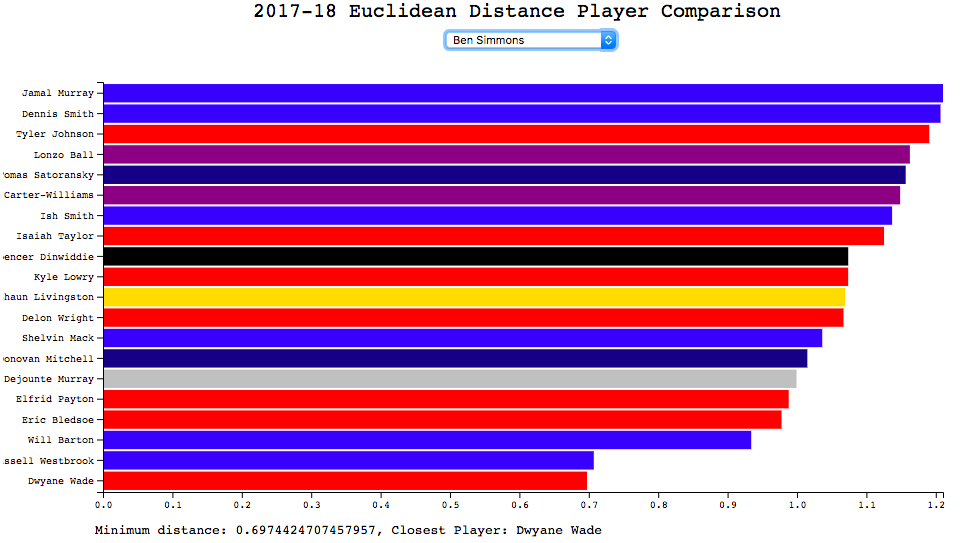

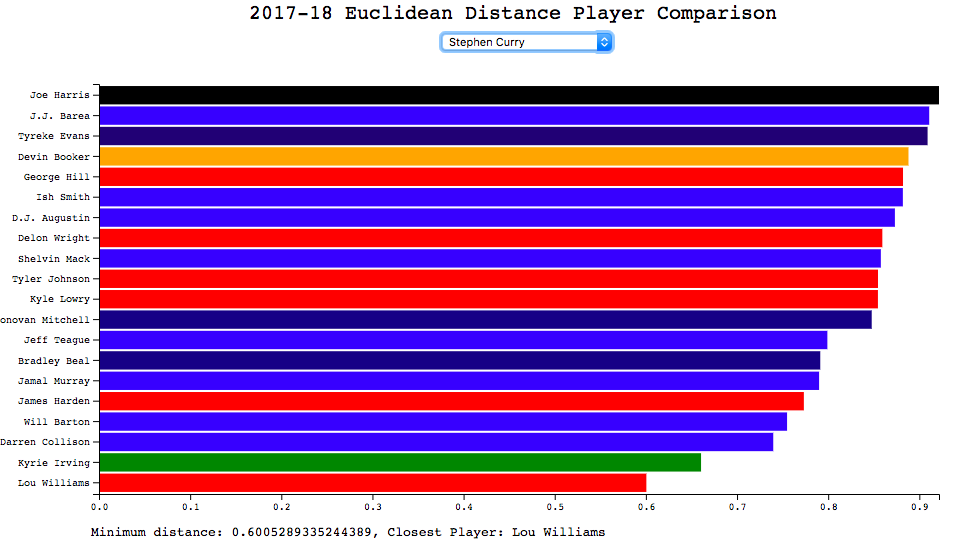

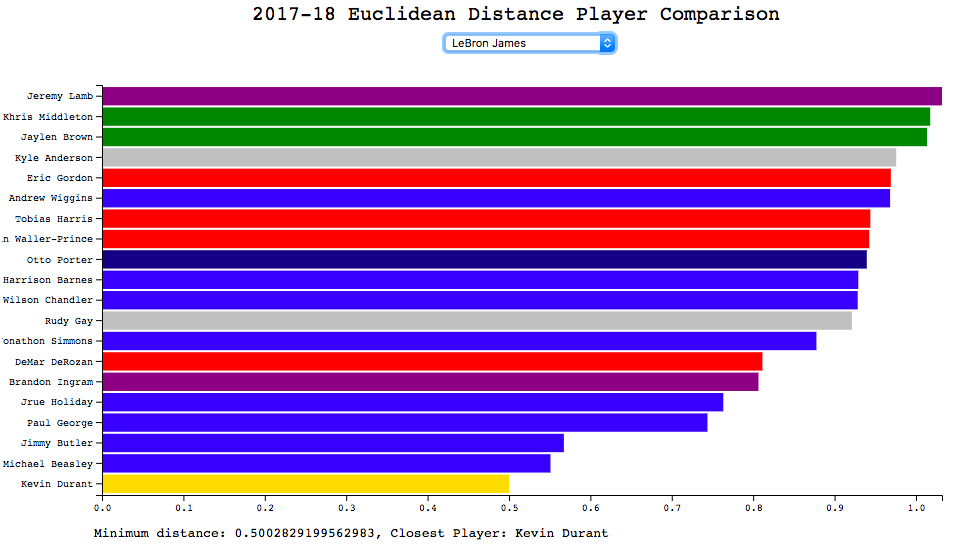

Now that we've defined the engine, let's actually compute the top *unicorns* in sorted order.

In [15]:
candidates = []
data = {}
with open('2017_18.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        try:
            if float(row['NUMDATA'])>2000:
                candidates.append(row['NAME'])
        except:
            pass
            
for c in candidates:
    data[c] = find_dist(c)    
    
unicorns = sorted(data.items(), key=lambda kv: kv[1])[::-1]
for i, el in enumerate(unicorns):
    print(f"{i}) {el[0]} (dist = {el[1]})")

0) Wayne Ellington (dist = 0.862853380807248)
1) Ben Simmons (dist = 0.8608940177599924)
2) Victor Oladipo (dist = 0.7839102062757385)
3) Carmelo Anthony (dist = 0.7795072039673809)
4) Dragan Bender (dist = 0.7721557155631702)
5) Marcus Smart (dist = 0.7420974460279544)
6) Kyle Anderson (dist = 0.7289090896379161)
7) Thaddeus Young (dist = 0.7137741070327206)
8) Andre Iguodala (dist = 0.7125512253931404)
9) Evan Turner (dist = 0.7077337405947076)
10) Stephen Curry (dist = 0.705805827234099)
11) Russell Westbrook (dist = 0.6992707410565906)
12) Kyle Korver (dist = 0.697107866287064)
13) Marc Gasol (dist = 0.6825375722364898)
14) Kevin Durant (dist = 0.6780464685963886)
15) Terry Rozier (dist = 0.6779222971529963)
16) Buddy Hield (dist = 0.6734394616685726)
17) Chris Paul (dist = 0.6709895409323444)
18) PJ Tucker (dist = 0.6694519541387791)
19) Nikola Jokic (dist = 0.658131361439047)
20) Draymond Green (dist = 0.6553919605657238)
21) T.J. Warren (dist = 0.6553097763843556)
22) George Hil

## Results
Here is the log of our players who differ the most in sorted order:
```
0) Wayne Ellington (dist = 0.862853380807248)
1) Ben Simmons (dist = 0.8608940177599924)
2) Victor Oladipo (dist = 0.7839102062757385)
3) Carmelo Anthony (dist = 0.7795072039673809)
4) Dragan Bender (dist = 0.7721557155631702)
5) Marcus Smart (dist = 0.7420974460279544)
6) Kyle Anderson (dist = 0.7289090896379161)
7) Thaddeus Young (dist = 0.7137741070327206)
8) Andre Iguodala (dist = 0.7125512253931404)
9) Evan Turner (dist = 0.7077337405947076)
10) Stephen Curry (dist = 0.705805827234099)
11) Russell Westbrook (dist = 0.6992707410565906)
12) Kyle Korver (dist = 0.697107866287064)
13) Marc Gasol (dist = 0.6825375722364898)
14) Kevin Durant (dist = 0.6780464685963886)
15) Terry Rozier (dist = 0.6779222971529963)
16) Buddy Hield (dist = 0.6734394616685726)
17) Chris Paul (dist = 0.6709895409323444)
18) PJ Tucker (dist = 0.6694519541387791)
19) Nikola Jokic (dist = 0.658131361439047)
20) Draymond Green (dist = 0.6553919605657238)
21) T.J. Warren (dist = 0.6553097763843556)
22) George Hill (dist = 0.6541111751252913)
23) E'Twaun Moore (dist = 0.6525313051469811)
24) Tyler Johnson (dist = 0.6463318121745889)
25) Darren Collison (dist = 0.643847491952064)
26) Joe Ingles (dist = 0.6407070236548652)
27) Khris Middleton (dist = 0.6399350039341346)
28) Dennis Schroder (dist = 0.6381520604552243)
29) JJ Redick (dist = 0.6342331622394565)
30) Andrew Wiggins (dist = 0.6335381811074859)
31) Al-Farouq Aminu (dist = 0.6311038067124873)
32) Jrue Holiday (dist = 0.6292587663139884)
33) Dario Saric (dist = 0.6278994148367752)
34) Jamal Murray (dist = 0.6278273881539742)
35) LeBron James (dist = 0.6251706068786544)
36) Kevin Love (dist = 0.6236893577562272)
37) Marcus Morris (dist = 0.6187950294485602)
38) Otto Porter (dist = 0.6166722684840595)
39) Wesley Matthews (dist = 0.6149515868358273)
40) Serge Ibaka (dist = 0.6144752509437653)
41) Justin Holiday (dist = 0.6137602482696499)
42) Dwight Howard (dist = 0.6135425807351385)
43) James Johnson (dist = 0.6135285681401947)
44) James Harden (dist = 0.6128291733001948)
45) Dennis Smith (dist = 0.6105197405638664)
46) Jayson Tatum (dist = 0.6102776870667763)
47) Allen Crabbe (dist = 0.6090623601976143)
48) Josh Richardson (dist = 0.6090135720397013)
49) Austin Rivers (dist = 0.6050097818887655)
50) Marvin Williams (dist = 0.6027806400396234)
51) Denzel Valentine (dist = 0.6022144921299393)
52) Spencer Dinwiddie (dist = 0.6009656724713572)
53) Bogdan Bogdanovic (dist = 0.599364711307845)
54) Harrison Barnes (dist = 0.599121800149805)
55) Klay Thompson (dist = 0.5982128656572023)
56) Kemba Walker (dist = 0.5950765655681535)
57) Darius Miller (dist = 0.5945881940206835)
58) Paul George (dist = 0.5930483279853771)
59) Gary Harris (dist = 0.5922667711714265)
60) Eric Bledsoe (dist = 0.5922051408334268)
61) Jonathon Simmons (dist = 0.5902300492262037)
62) Jimmy Butler (dist = 0.5893338057685883)
63) Robert Covington (dist = 0.5877124748607112)
64) Ish Smith (dist = 0.5861190898549536)
65) Goran Dragic (dist = 0.5833172809667433)
66) Kyle Lowry (dist = 0.5815556144653312)
67) Taj Gibson (dist = 0.5813990670433743)
68) Will Barton (dist = 0.581389352675248)
69) Lauri Markkanen (dist = 0.5804340920096919)
70) Tobias Harris (dist = 0.5772177965343959)
71) DeMar DeRozan (dist = 0.5747190859294238)
72) Lou Williams (dist = 0.5707579075758957)
73) CJ McCollum (dist = 0.5702131333875796)
74) Tony Snell (dist = 0.5696839327419153)
75) Jeff Green (dist = 0.5695559669805933)
76) Steven Adams (dist = 0.5672629151778039)
77) Kyle Kuzma (dist = 0.5669775607910369)
78) Jordan Clarkson (dist = 0.5647519206170933)
79) Jae Crowder (dist = 0.5620532077391843)
80) Bojan Bogdanovic (dist = 0.5619569168933047)
81) Ricky Rubio (dist = 0.5619455588540498)
82) DeMarre Carroll (dist = 0.5586312071358623)
83) Eric Gordon (dist = 0.5554265162136751)
84) Karl-Anthony Towns (dist = 0.5521631198530887)
85) Trevor Ariza (dist = 0.5494974748627285)
86) Cory Joseph (dist = 0.5494883190009923)
87) JR Smith (dist = 0.544837598114848)
88) Courtney Lee (dist = 0.5408136926093935)
89) Myles Turner (dist = 0.537919170701891)
90) Marcin Gortat (dist = 0.5368822847162139)
91) Wilson Chandler (dist = 0.5356919131712721)
92) DeAndre Jordan (dist = 0.5349709522109952)
93) Yogi Ferrell (dist = 0.5344258953569833)
94) Jusuf Nurkic (dist = 0.5264365764922243)
95) Jeff Teague (dist = 0.5258767992761911)
96) Bradley Beal (dist = 0.5255933797268015)
97) Damian Lillard (dist = 0.5235120654983891)
98) Kentavious Caldwell-Pope (dist = 0.516457321635334)
99) Kelly Oubre (dist = 0.5161171191605949)
100) Al Horford (dist = 0.5158130610500418)
101) De'Aaron Fox (dist = 0.5150351572907784)
102) Anthony Davis (dist = 0.5085308445707494)
103) Marco Belinelli (dist = 0.5072067084997718)
104) Taurean Waller-Prince (dist = 0.5059821210360783)
105) Dillon Brooks (dist = 0.5013422475568798)
106) LaMarcus Aldridge (dist = 0.498348833564493)
107) Patty Mills (dist = 0.4943116036544817)
108) Rajon Rondo (dist = 0.4936534982189754)
109) Willie Cauley-Stein (dist = 0.4929512656830591)
110) Julius Randle (dist = 0.4925675524554339)
111) Andre Drummond (dist = 0.4890505141301533)
112) Jaylen Brown (dist = 0.4870379492984358)
113) Clint Capela (dist = 0.48601812505755576)
114) Donovan Mitchell (dist = 0.47948805512370907)
115) Derrick Favors (dist = 0.47699705645265233)
116) John Henson (dist = 0.4654552579602349)
117) Giannis Antetokounmpo (dist = 0.45533099011216704)
118) Rudy Gobert (dist = 0.4498948114159876)
119) Joel Embiid (dist = 0.44968284077287135)
120) Markieff Morris (dist = 0.44241739801427576)
```

Evidently, we can see that The Ringer's Unicorns are different than mine.

## Conclusions
I've displayed the results of my player comparison engine on each of The Ringer's Unicorns below

We can see that several of The Ringer's unicorns actually *clump* together.

There's a group of unicorns such as Joel Embiid, Anthony Davis, Giannis Antetokoumpo, Karl-Anthony Towns and non-unicorns Aaron Gordon, and LaMarcus Aldridge who I would count as 'big men who can shoot jumpers'. Of course, The Ringer bunches these together just because they're a *new class* of players we haven't encountered before.

My unicorns are based on the list above and a little subjectivity. The term 'unicorn' implies something special, so I picked the top players from my list and filtered by players who I thought were special and unique. This meant that, unfortunately, Wayne Ellington would **NOT** be making my list.
My list consisted of:
```
1) Ben Simmons
2) Victor Oladipo
3) Stephen Curry
4) Russell Westbrook
5) Kevin Durant
6) Nikola Jokic
```
[Here](https://imgur.com/a/OLAd4op) is a link to their player comparison visualizations.

I thought these were much more 'unicorny' players as their distances were almost all above 0.6. The one exception was, KD, who was EXTREMELY similar to LeBron. I thought this was funny, especially with all the talk about how KD wanted to be so much like LeBron OFF the court. Apparently he modeled his game after him too!